In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Подсчитывает расстояние Хэмминга
def vector_dist(vect1, vect2):
    return np.sum(np.abs(vect1 - vect2))

# Перемножает матрицы в F2
def multiply_matrix(mat1, mat2):
    return np.mod(np.dot(mat1, mat2), 2)

# Получает все возможные двоичные вектора заданной длины
def generate_binary_vectors(vect_len):
    def get_all_vectors(vector_len, cur_vectors):
        if len(cur_vectors[0]) == vector_len: # если вектора уже нужного размера, возвращаем их
            return cur_vectors
        
        # в противном случае каждый вектор может быть продолжен двумя способами:
        # нулём и единицей
        new_vectors = []
        for cur_vector in cur_vectors:
            cur_vector_zero = cur_vector[:]
            cur_vector_zero.append(0)

            cur_vector_one = cur_vector[:]
            cur_vector_one.append(1)
            new_vectors.append(cur_vector_zero)
            new_vectors.append(cur_vector_one)
        return get_all_vectors(vector_len, new_vectors)
    
    answer = get_all_vectors(vect_len, [[]])
    assert len(answer) == 2 ** vect_len
    
    # оборачиваем в numpy-массивы для ускорения вычислений
    return np.array(answer)

In [3]:
# Порождающая матрица
G = np.array(
    [
        [1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
    ]
)

# 6 - размер сообщения до кодирования
# 10 - размер сообщения после кодирования
k = 6
n = 10

Eb = 1 # Фиксируем произвольным образом энергию на передаваемый бит

# Передаваемые сообщения - все вектора размера k
messages = generate_binary_vectors(k)
assert messages.shape == (2 ** k, k)

In [4]:
# Проверочная матрица
H = np.array(
    [
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
    ]
)

H_T = np.transpose(H)
assert (multiply_matrix(G, H_T) == np.zeros(shape=(6, 4))).all()

In [5]:
codewords = np.array([
    multiply_matrix(cur_message, G) for cur_message in messages
])

assert codewords.shape == (2 ** k, n)

In [6]:
# При жёстком декодировании полученный вектор должен быть битовым
# а при мягком - состоять из модуляций    
def decode_hard(received_word, codewords):
    distances = np.array([vector_dist(received_word, cur_codeword) for cur_codeword in codewords])
    return messages[np.argmin(distances)]

def decode_soft(received_word, codewords):
    modulated_codewords = np.array([(2 * codeword - 1) for codeword in codewords])
    scalar_products = np.array([
        np.dot(cur_modulated_codeword, received_word) for cur_modulated_codeword in modulated_codewords
    ])
    return messages[np.argmax(scalar_products)]
    
# преобразует полученные модуляции в биты для жёсткого декодирования
# в случае мягкого декодирования никак преобразовывать модуляции не надо
demodulate_hard = np.vectorize(lambda x: 1 if x >= 0 else 0)    
    
# 10 * lg(Eb / N0) = t => lg(Eb / N0) = t / 10 => Eb / N0 = 10 ** (t / 10) => N0 = Eb / (10 ** (t / 10))
# Таким образом можно вычислить N0
# моделирует отправку по каналу с аддитивным белым гауссовским шумом
def send(codeword_to_send, snr):
    N0 = Eb / (10 ** (snr / 10)) # по отношению сингал/шум получаем N0
    Ec = Eb * k / len(codeword_to_send) # энергия на передаваемый символ
    noise = np.random.normal(0, math.sqrt(N0 / 2), len(codeword_to_send)) # добавляем аддитивный гауссовский белый шум
    return (2 * codeword_to_send - 1) * math.sqrt(Ec) + noise

In [7]:
# Моделирует отправку сообщения с кодированием
def send_with_encoding(msg, snr, decoder_type):
    code_word = multiply_matrix(msg, G) # По шестибитному слову получаем десятибитный код
    # внося избыточность в данные
    moduled_received = send(code_word, snr) # Превращение бит в модуляции и добавление АБГШ
    if decoder_type == 'hard':
        received_word = demodulate_hard(moduled_received)
        received_msg = decode_hard(received_word, codewords)
    else:
        received_msg = decode_soft(moduled_received, codewords)
    return vector_dist(msg, received_msg)

# Моделирует отправку сообщения без кодирования
def send_without_encoding(msg, snr, decoder_type):
    signals = send(msg, snr)
    if decoder_type == 'hard':
        return vector_dist(msg, demodulate_hard(signals))
    else:
        received_msg = decode_soft(signals, messages)
        return vector_dist(msg, received_msg)

In [8]:
# message_sender - функция, используемая для моделирования отправки сообщения. Может
# быть функцией с кодированием, а может без
def get_p(snr, message_sender, decoder_type):
    sum_res = 0
    retries = 10000
    for _ in range(retries):
        for msg in messages:
            sum_res += message_sender(msg, snr, decoder_type)
    return sum_res / (retries * (2 ** k) * k)   

In [9]:
snrs = list(np.arange(-2, 12, 0.25)) # различные отношения сигнал/шум
p = 0.00001

In [10]:
hard_encode = np.array([get_p(cur_snr, send_with_encoding, 'hard') for cur_snr in tqdm(snrs)])

100%|██████████| 56/56 [3:53:57<00:00, 250.66s/it]  


In [11]:
hard_no_encode = np.array([get_p(cur_snr, send_without_encoding, 'hard') for cur_snr in tqdm(snrs)])

100%|██████████| 56/56 [23:11<00:00, 24.86s/it]


In [12]:
hard_encode_abs = abs(hard_encode - p)
hard_no_encode_abs = abs(hard_no_encode - p)
snrs[np.argmin(hard_no_encode_abs)] - snrs[np.argmin(hard_encode_abs)]
# энергетический выигрыш на жёстком декодировании

0.25

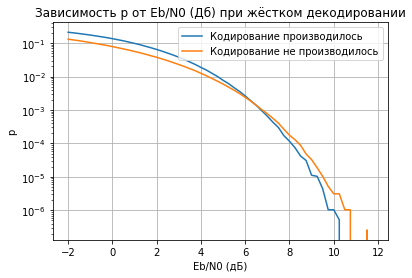

In [13]:
plt.semilogy(snrs, hard_encode, label='Кодирование производилось')
plt.semilogy(snrs, hard_no_encode, label='Кодирование не производилось')
plt.legend(loc='upper right')
plt.title('Зависимость p от Eb/N0 (Дб) при жёстком декодировании')
plt.xlabel('Eb/N0 (дБ)')
plt.ylabel('p')
plt.grid(which='major')
plt.show()

In [14]:
soft_encode = np.array([get_p(cur_snr, send_with_encoding, 'soft') for cur_snr in tqdm(snrs)])

100%|██████████| 56/56 [2:42:18<00:00, 173.90s/it]  


In [15]:
soft_no_encode = np.array([get_p(cur_snr, send_without_encoding, 'soft') for cur_snr in tqdm(snrs)])

100%|██████████| 56/56 [8:07:12<00:00, 522.00s/it]    


In [16]:
soft_encode_abs = abs(soft_encode - p)
soft_no_encode_abs = abs(soft_no_encode - p)
snrs[np.argmin(soft_no_encode_abs)] - snrs[np.argmin(soft_encode_abs)]
# энергетический выигрыш на мягком декодировании

2.5

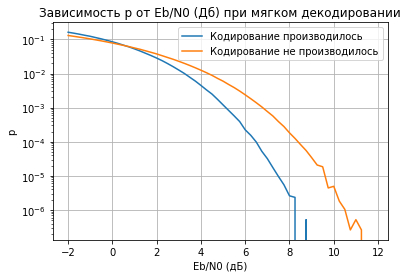

In [17]:
plt.semilogy(snrs, soft_encode, label='Кодирование производилось')
plt.semilogy(snrs, soft_no_encode, label='Кодирование не производилось')
plt.legend(loc='upper right')
plt.title('Зависимость p от Eb/N0 (Дб) при мягком декодировании')
plt.xlabel('Eb/N0 (дБ)')
plt.ylabel('p')
plt.grid(which='major')
plt.show()